<a href="https://colab.research.google.com/github/khalidpark/machinelearning_whitepaper/blob/main/Machine_learning_whitepaper_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 로드

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 타겟을 정합니다.
target = 'vacc_seas_f'
# 학습데이터 features, labels 를 병합합니다.
train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv')



# 80/20 비율로 학습/테스트 데이터를 분리합니다.
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)

def engineer(df):
    """특성을 엔지니어링 하는 함수입니다."""
    
    # 새로운 특성을 생성합니다.
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behaviorals'] = df[behaviorals].sum(axis=1)
    
    dels = [col for col in df.columns if ('employment' in col or 'h1n1' in col)]
    df.drop(columns=dels, inplace=True)
        
    return df

train = engineer(train)
val = engineer(val)
test = engineer(test)


In [4]:
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test


In [6]:
!pip install category_encoders

     |████████████████████████████████| 81kB 4.4MB/s 


In [7]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
pipe


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=None, drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=None, return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('randomforestclassifier',
                 RandomForestClassifier...rap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                      

In [9]:
from sklearn.metrics import classification_report
# train 학습, 검증셋 정확도
pipe.fit(X_train, y_train)
print('검증 정확도', pipe.score(X_val, y_val))

print(classification_report(y_val, pipe.predict(X_val)))


검증 정확도 0.7526983750444787
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      4608
           1       0.74      0.70      0.72      3823

    accuracy                           0.75      8431
   macro avg       0.75      0.75      0.75      8431
weighted avg       0.75      0.75      0.75      8431





---



# 방법 1 : Feature Importances(Mean decrease impurity, MDI)

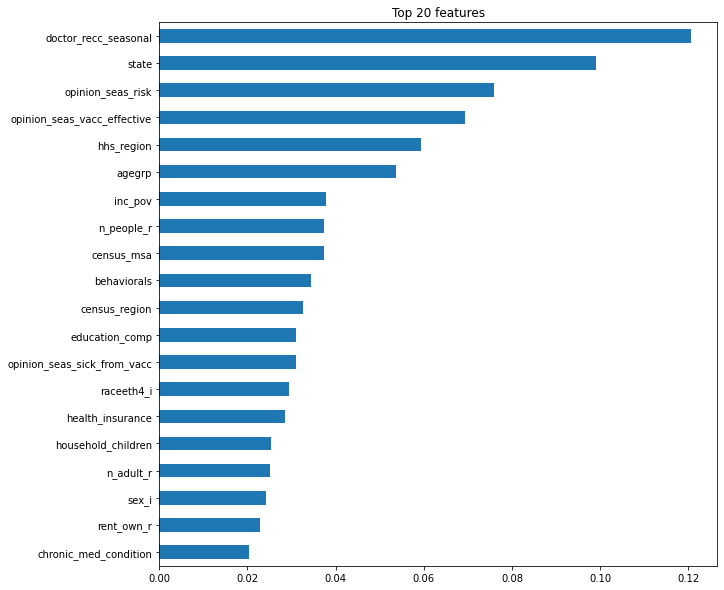

In [10]:
# 특성 중요도
rf = pipe.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();


특성 중요도가 높게 나온 state는 유의

51개 카테고리로 구성되어 있는데 다른 특성과 비교하여 상대적으로 high-cardinarity 특성 

트리 구성 중 분기에 이용될 확률이 높아 과적합 위험

# 방법2 : Drop-Column Importance

In [11]:
column  = 'opinion_seas_risk'

# opinion_h1n1_risk 없이 fit
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
)
pipe.fit(X_train.drop(columns=column), y_train)
score_without = pipe.score(X_val.drop(columns=column), y_val)
print(f'검증 정확도 ({column} 제외): {score_without}')

# opinion_h1n1_risk 포함 후 다시 학습
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
)
pipe.fit(X_train, y_train)
score_with = pipe.score(X_val, y_val)
print(f'검증 정확도 ({column} 포함): {score_with}')

# opinion_h1n1_risk 포함 전 후 정확도 차이를 계산합니다
print(f'{column}의 Drop-Column 중요도: {score_with - score_without}')


검증 정확도 (opinion_seas_risk 제외): 0.733127742853754
검증 정확도 (opinion_seas_risk 포함): 0.7526983750444787
opinion_seas_risk의 Drop-Column 중요도: 0.019570632190724635


이론적으로 가장 좋아 보이는 방법, 

매 특성을 drop한 후 fit을 다시 해야 하기 때문에 매우 느리다는 단점

특성이 n개 존재할 때 n + 1 번 학습이 필요

# 방법 3 : 순열중요도, (Permutation Importance, Mean Decrease Accuracy,MDA)

순열 중요도는 기본 특성 중요도와 Drop-column 중요도 중간에 위치하는 특징



In [12]:
# 변경 할 특성을 선택합니다
feature = 'opinion_seas_risk'
X_val[feature].head()


11966     Somewhat Low
1211          Very Low
4407      Somewhat Low
1827     Somewhat High
23988              NaN
Name: opinion_seas_risk, dtype: object

In [13]:
# 특성의 분포를 확인합니다
X_val[feature].value_counts()

Somewhat Low     2300
Somewhat High    1875
Very Low         1505
Very High         780
Dont Know         175
Refused            11
Name: opinion_seas_risk, dtype: int64

In [15]:
# 특성의 값을 무작위로 섞습니다
X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.RandomState(seed=7).permutation(X_val_permuted[feature])


In [16]:
# 특성 값의 순서가 뒤바뀐 것을 확인합니다
X_val_permuted[feature].head()


11966     Somewhat Low
1211     Somewhat High
4407     Somewhat High
1827               NaN
23988         Very Low
Name: opinion_seas_risk, dtype: object

In [17]:
# 카테고리들의 분포는 바뀌지는 않았음을 확인합니다
X_val_permuted[feature].value_counts()


Somewhat Low     2300
Somewhat High    1875
Very Low         1505
Very High         780
Dont Know         175
Refused            11
Name: opinion_seas_risk, dtype: int64

In [18]:
# 순열 중요도 값을 얻습니다. (재학습이 필요 없습니다!)
score_permuted = pipe.score(X_val_permuted, y_val)

print(f'검증 정확도 ({feature}): {score_with}')
print(f'검증 정확도 (permuted "{feature}"): {score_permuted}')
print(f'순열 중요도: {score_with - score_permuted}')


검증 정확도 (opinion_seas_risk): 0.7526983750444787
검증 정확도 (permuted "opinion_seas_risk"): 0.7205550942948642
순열 중요도: 0.03214328074961448


In [19]:
# doctor_recc_h1n1 에 대해서 순열 중요도를 계산해 봅시다
feature = 'doctor_recc_seasonal'
X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.permutation(X_val_permuted[feature])
score_permuted = pipe.score(X_val_permuted, y_val)

print(f'검증 정확도 ({feature}): {score_with}')
print(f'검증 정확도 (permuted "{feature}"): {score_permuted}')
print(f'순열 중요도: {score_with - score_permuted}')


검증 정확도 (doctor_recc_seasonal): 0.7526983750444787
검증 정확도 (permuted "doctor_recc_seasonal"): 0.6811766101292848
순열 중요도: 0.07152176491519391


### eli5 라이브러를 사용

In [20]:
from sklearn.pipeline import Pipeline
# encoder, imputer를 preprocessing으로 묶었습니다. 후에 eli5 permutation 계산에 사용합니다
pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)) 
])


In [21]:
# pipeline 생성을 확인합니다.
pipe.named_steps


{'preprocessing': Pipeline(memory=None,
          steps=[('ordinalencoder',
                  OrdinalEncoder(cols=None, drop_invariant=False,
                                 handle_missing='value', handle_unknown='value',
                                 mapping=None, return_df=True, verbose=0)),
                 ('simpleimputer',
                  SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                                missing_values=nan, strategy='mean',
                                verbose=0))],
          verbose=False),
 'rf': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
         

In [22]:
pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_val, y_val))


검증 정확도:  0.7526983750444787


In [24]:
!pip install eli5

     |████████████████████████████████| 112kB 8.5MB/s 


In [26]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    pipe.named_steps['rf'], # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_val_transformed = pipe.named_steps['preprocessing'].transform(X_val)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val_transformed, y_val);


In [27]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()


n_adult_r                     -0.003511
hhs_region                    -0.003108
census_region                 -0.003084
behavioral_face_mask          -0.003060
sex_i                         -0.002942
state                         -0.002918
behavioral_wash_hands         -0.002657
n_people_r                    -0.002562
behavioral_large_gatherings   -0.002538
behavioral_antiviral_meds     -0.002420
behavioral_avoidance          -0.002159
behavioral_outside_home       -0.002064
behavioral_touch_face         -0.001755
chronic_med_condition         -0.001613
census_msa                    -0.001542
behaviorals                   -0.001471
child_under_6_months          -0.001400
marital                       -0.001328
rent_own_r                    -0.000712
inc_pov                       -0.000474
raceeth4_i                    -0.000213
household_children            -0.000119
education_comp                 0.001234
health_insurance               0.002775
health_worker                  0.003060


In [28]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)


Weight,Feature
0.0714 ± 0.0047,doctor_recc_seasonal
0.0438 ± 0.0034,opinion_seas_vacc_effective
0.0410 ± 0.0032,opinion_seas_risk
0.0077 ± 0.0028,agegrp
0.0048 ± 0.0019,opinion_seas_sick_from_vacc
0.0031 ± 0.0026,health_worker
0.0028 ± 0.0020,health_insurance
0.0012 ± 0.0043,education_comp
-0.0001 ± 0.0025,household_children
-0.0002 ± 0.0028,raceeth4_i


중요도를 이용하여 특성을 선택(Feature selection)

In [29]:
print('특성 삭제 전:', X_train.shape, X_val.shape)


특성 삭제 전: (33723, 30) (8431, 30)


In [30]:
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train_selected = X_train[features]
X_val_selected = X_val[features]


In [31]:
print('특성 삭제 후:', X_train_selected.shape, X_val_selected.shape)


특성 삭제 후: (33723, 8) (8431, 8)


In [32]:
# pipeline 다시 정의
pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)) 
], verbose=1)

pipe.fit(X_train_selected, y_train);


[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.1s
[Pipeline] ................ (step 2 of 2) Processing rf, total=   1.6s


In [33]:
print('검증 정확도: ', pipe.score(X_val_selected, y_val))


검증 정확도:  0.7513936662317637




---

